In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import differential_evolution

from tqdm.auto import trange

from leo_vetter.thresholds import check_thresholds

In [7]:
def get_FA_FP(thresholds, scr, inj, obs):
    # FAs are noise/systematic false alarms
    scr_FA = check_thresholds(scr, "FA", thresholds=thresholds)
    inj_FA = check_thresholds(inj, "FA", thresholds=thresholds)
    obs_FA = check_thresholds(obs, "FA", thresholds=thresholds)
    # FPs are astrophysical false positives, not including FAs
    scr_FP = check_thresholds(scr, "FP", thresholds=thresholds) & ~scr_FA
    inj_FP = check_thresholds(inj, "FP", thresholds=thresholds) & ~inj_FA
    obs_FP = check_thresholds(obs, "FP", thresholds=thresholds) & ~obs_FA
    return scr_FA, inj_FA, obs_FA, scr_FP, inj_FP, obs_FP

def compute_completeness_reliability(thresholds, scr, inj, obs, 
                                     dim1="spn", dim1Range=[0, np.inf], 
                                     dim2="N_transit", dim2Range=[0, np.inf]):

    scr_FA, inj_FA, obs_FA, scr_FP, inj_FP, obs_FP = get_FA_FP(thresholds, scr, inj, obs)
    
    # PCs are planet candidates: not FAs and not FPs
    scr_PC = ~scr_FA & ~scr_FP
    inj_PC = ~inj_FA & ~inj_FP
    obs_PC = ~obs_FA & ~obs_FP

    # FPs and PCs
    scr_notFA = ~scr_FA
    obs_notFA = ~obs_FA
    inj_notFA = ~inj_FA
    
    # Get subset of signals within bin
    scr_tmp = (scr[dim1] >= dim1Range[0]) & (scr[dim1] < dim1Range[1]) &\
              (scr[dim2] >= dim2Range[0]) & (scr[dim2] < dim2Range[1])
    inj_tmp = (inj[dim1] >= dim1Range[0]) & (inj[dim1] < dim1Range[1]) &\
              (inj[dim2] >= dim2Range[0]) & (inj[dim2] < dim2Range[1])
    obs_tmp = (obs[dim1] >= dim1Range[0]) & (obs[dim1] < dim1Range[1]) &\
              (obs[dim2] >= dim2Range[0]) & (obs[dim2] < dim2Range[1])
    
    N_scr = len(scr[scr_tmp]) # number of scrambled TCEs
    N_inj = len(inj[inj_tmp]) # number of injected TCEs
    N_obs = len(obs[obs_tmp]) # number of observed TCEs

    N_scrFA = len(scr[scr_FA & scr_tmp]) # number of scrambled FAs
    N_injPC = len(inj[inj_PC & inj_tmp]) # number of injected PCs
    N_obsPC = len(obs[obs_PC & obs_tmp]) # number of observed PCs
    N_obsFA = len(obs[obs_FA & obs_tmp]) # number of observed FAs
    N_obsFP = len(obs[obs_FP & obs_tmp]) # number of observed FPs
    N_notFA = len(obs[~obs_FA & obs_tmp]) # number of observed non-FAs

    # Compute completeness - fraction of INJ TCEs marked as PCs
    try:
        C = N_injPC/N_inj
    except ZeroDivisionError:
        C = np.nan
        
    # Compute effectiveness - fraction of SCR TCEs marked as FAs
    try:
        E = N_scrFA/N_scr
    except ZeroDivisionError:
        E = np.nan

    # Compute reliability against false alarms
    if N_notFA > 0:
        R = 1 - N_obsFA/N_notFA * (1 - E)/E
    else:
        R = np.nan

    TC = len(inj[inj_PC])/len(inj)*100 # total completeness
    TE = len(scr[scr_FA])/len(scr)*100 # total effectiveness
    TR = 1 - len(obs[obs_FA])/len(obs[~obs_FA]) * (1 - TE/100.)/(TE/100.) # total reliability
    
    return C, E, R, TC, TE, TR, N_scr, N_inj, N_obs, N_scrFA, N_injPC, N_obsPC, N_obsFA, N_obsFP

In [8]:
def get_fit_thresholds(thresholds, bounds):
    fit_thresholds = []
    fit_bounds = []
    fit_keys = []
    for key in thresholds.keys():
        if key in bounds:
            fit_thresholds.append(thresholds[key])
            fit_bounds.append(bounds[key])
            fit_keys.append(key)
    return np.array(fit_thresholds), fit_bounds, fit_keys

def get_all_thresholds(fit_thresholds, fit_keys, thresholds):
    thresh = thresholds.copy()
    for i, key in enumerate(fit_keys):
        thresh[key] = fit_thresholds[i]
    return thresh    

def bounds_to_list(inBounds):
    outBounds = []
    for i, k in enumerate(inBounds.keys()):
        outBounds.append(inBounds[k])
    return outBounds

def optFun(fit_thresholds, fit_keys, thresholds, scr, inj, obs):
    thresh = get_all_thresholds(fit_thresholds, fit_keys, thresholds)
    C, E, R, TC, TE, TR, N_scr, N_inj, N_obs, N_scrFA, N_injPC, N_obsPC, N_obsFA, N_obsFP \
        = compute_completeness_reliability(thresh, scr, inj, obs)
    return np.sqrt((R-1)**2 + (C-1)**2)

def report_thresh(thresholds, scr, inj, obs):
    C, E, R, TC, TE, TR, N_scr, N_inj, N_obs, N_scrFA, N_injPC, N_obsPC, N_obsFA, N_obsFP \
        = compute_completeness_reliability(thresholds, scr, inj, obs)
    print(f"Completeness = {C}, Effectiveness = {E}, Reliability = {R}\n" +\
          f"Distance from 100% completeness and reliability: {np.sqrt((R-1)**2 + (C-1)**2)}\n" +\
          f"{N_obsPC} PCs, {N_obsFP} FPs, {N_obsFA} FAs, {N_scr - N_scrFA} FAs passed\n" +\
          f"{N_scr} scrambled TCEs, {N_inj} injected TCEs, {N_obs} observed TCEs")

In [9]:
def run_optimizer(initThresholds, threshBounds, scr, inj, obs):
    print("Initial thresholds:")
    report_thresh(initThresholds, scr, inj, obs)
    fit_thresholds, fit_bounds, fit_keys = get_fit_thresholds(initThresholds, threshBounds)
    diffEvoResult = differential_evolution(optFun, bounds_to_list(threshBounds), args=(fit_keys, initThresholds, scr, inj, obs), disp=True)
    print("Differential evolution threholds:")
    diffEvoThresholds = get_all_thresholds(diffEvoResult.x, fit_keys, initThresholds)
    report_thresh(diffEvoThresholds, scr, inj, obs)
    return diffEvoThresholds

In [10]:
def plot_results(thresholds, scr, inj, obs, dim1, dim1Range, dim1Label, dim2, dim2Range, dim2Label, savefile=None, more=False, fs=12, figsize=(7,12)):
    C = np.zeros((len(dim1Range)-1,len(dim2Range)-1)) # completeness
    E = np.zeros((len(dim1Range)-1,len(dim2Range)-1)) # effectiveness
    R = np.zeros((len(dim1Range)-1,len(dim2Range)-1)) # reliability
    fig, ax = plt.subplots(3,1, figsize=figsize)
    for i in range(len(dim1Range)-1):
        for j in range(len(dim2Range)-1):
            C[i,j], E[i,j], R[i,j], _, _, _, N_scr, N_inj, N_obs, N_scrFA, N_injPC, N_obsPC, N_obsFA, N_obsFP \
                = compute_completeness_reliability(thresholds, scr, inj, obs, 
                                               dim1=dim1, dim1Range=[dim1Range[i], dim1Range[i+1]], 
                                               dim2=dim2, dim2Range=[dim2Range[j], dim2Range[j+1]])
            if more:
                ax[0].text(j, i, "{:.3f}%\n({:.0f}/{:.0f})".format(C[i,j]*100,N_injPC,N_inj), ha="center",va="center",color="k")
            else:
                ax[0].text(j, i, "{:.1f}%\n({:.0f}/{:.0f})".format(C[i,j]*100,N_injPC,N_inj), ha="center",va="center",color="k")
            if ~np.isnan(E[i,j]):
                if more:
                    ax[1].text(j, i, "{:.3f}%\n({:.0f}/{:.0f})".format(E[i,j]*100,N_scrFA,N_scr), ha="center",va="center",color="k")
                else:
                    ax[1].text(j, i, "{:.1f}%\n({:.0f}/{:.0f})".format(E[i,j]*100,N_scrFA,N_scr), ha="center",va="center",color="k")
            if R[i,j] < 0.2:
                rColor = "w"
            else:
                rColor = "k"
            if N_obsPC == 0:
                R[i,j] =  np.nan
            if ~np.isnan(R[i,j]):
                if N_obsPC == 1:
                    str = "PC"
                else:
                    str = "PCs"
                if more:
                    ax[2].text(j, i, "{:.3f}%\n{:.0f} {}".format(R[i,j]*100,N_obsPC,str), fontsize=10, ha="center",va="center",color=rColor)
                else:
                    ax[2].text(j, i, "{:.1f}%\n{:.0f} {}".format(R[i,j]*100,N_obsPC,str), fontsize=10, ha="center",va="center",color=rColor)
    
    im0 = ax[0].imshow(C,origin="lower",vmin=0,vmax=1,aspect="auto")
    im1 = ax[1].imshow(E,origin="lower",vmin=0,vmax=1,aspect="auto")
    im2 = ax[2].imshow(R,origin="lower",vmin=0,vmax=1,aspect="auto")
    fig.colorbar(im0, ax=ax[0])
    fig.colorbar(im1, ax=ax[1])
    fig.colorbar(im2, ax=ax[2])
    ax[0].set_title("Completeness",fontsize=fs)
    ax[1].set_title("Effectiveness",fontsize=fs)
    ax[2].set_title("False Alarm Reliability",fontsize=fs)
    for a in [ax[0], ax[1], ax[2]]:
        a.set_xticks(np.linspace(-0.5,len(dim2Range)-1.5,len(dim2Range)))
        a.set_yticks(np.linspace(-0.5,len(dim1Range)-1.5,len(dim1Range)))
        a.set_xticklabels(["{:.0f}".format(p) for p in dim2Range], fontsize=fs)
        a.set_yticklabels(["{:.0f}".format(s) for s in dim1Range], fontsize=fs)
        a.set_xlabel(dim2Label, fontsize=fs)
        a.set_ylabel(dim1Label, fontsize=fs)
    fig.subplots_adjust(hspace=0.3)
    if savefile is not None:
        plt.savefig(savefile, bbox_inches="tight")

In [11]:
initThresholds = {} # initial guess for differential evolution algorithm
threshBounds = {} # bounds on metric thresholds

# Metric thresholds to be fitted
initThresholds["MES"] = 6.2
threshBounds["MES"] = (5,10)
initThresholds["MS1"] = 0.2
threshBounds["MS1"] = (0,2)
initThresholds["MS2"] = 0.8
threshBounds["MS2"] = (0,2)
initThresholds["MS3"] = 0.8
threshBounds["MS3"] = (0,2)
initThresholds["max_SES_to_MES"] = 0.88
threshBounds["max_SES_to_MES"] = (0.6,1)
initThresholds["SWEET"] = 15
threshBounds["SWEET"] = (5,20)
initThresholds["CHI"] = 7.8
threshBounds["CHI"] = (3,10)
initThresholds["DMM"] = 1.5
threshBounds["DMM"] = (1,2)
initThresholds["chases"] = 0.78
threshBounds["chases"] = (0.5,0.9)
initThresholds["AIC1"] = -60
threshBounds["AIC1"] = (-100,0)
initThresholds["AIC2"] = -30
threshBounds["AIC2"] = (-100,0)
initThresholds["frac_gap"] = 0.5
threshBounds["frac_gap"] = (0.2,1)
initThresholds["ASYM"] = 10
threshBounds["ASYM"] = (3,15)
initThresholds["SHP"] = 0.6
threshBounds["SHP"] = (0.2, 0.8)

# Metric thresholds to be fixed
initThresholds["N_transit"] = 3
initThresholds["V_shape"] = 1.5
initThresholds["size"] = 22
initThresholds["MS4"] = 0
initThresholds["MS5"] = -1
initThresholds["MS6"] = -1

`scr` contains the metrics for scrambled TCEs; `inj` contains injected TCEs; and `obs` contains observed TCEs. To reduce filesize, we are only demonstrating this code on 10,000 TCEs in each dataset.

In [12]:
scr = pd.read_csv("scr_subset.csv")
inj = pd.read_csv("inj_subset.csv")
obs = pd.read_csv("obs_subset.csv")

In [33]:
diffEvoThresholds = run_optimizer(initThresholds, threshBounds, scr, inj, obs)

Initial thresholds:
Completeness = 0.9072, Effectiveness = 0.9991, Reliability = 0.9682627408145588
Distance from 100% completeness and reliability: 0.09807697803564236
167 PCs, 109 FPs, 9724 FAs, 9 FAs passed
10000 scrambled TCEs, 10000 injected TCEs, 10000 observed TCEs
differential_evolution step 1: f(x)= 0.10608309834019612
differential_evolution step 2: f(x)= 0.10608309834019612
differential_evolution step 3: f(x)= 0.1046819981659792
differential_evolution step 4: f(x)= 0.10269586946476127
differential_evolution step 5: f(x)= 0.10269586946476127
differential_evolution step 6: f(x)= 0.10269586946476127
differential_evolution step 7: f(x)= 0.10269586946476127
differential_evolution step 8: f(x)= 0.10218472452173406
differential_evolution step 9: f(x)= 0.1010320880828096
differential_evolution step 10: f(x)= 0.10014717418907901
differential_evolution step 11: f(x)= 0.09884027126683
differential_evolution step 12: f(x)= 0.09884027126683
differential_evolution step 13: f(x)= 0.09884027

In [34]:
diffEvoThresholds

{'MES': 6.708004639385543,
 'MS1': 0.09782209937922248,
 'MS2': 0.2548868185524189,
 'MS3': 0.9588449393207652,
 'max_SES_to_MES': 0.8940297055244104,
 'SWEET': 16.49213303183156,
 'CHI': 8.365762099220614,
 'DMM': 1.4137355062153478,
 'chases': 0.7817535394646715,
 'AIC1': -53.5807304876502,
 'AIC2': -8.86366629349272,
 'frac_gap': 0.4863428577468594,
 'ASYM': 12.733416568158795,
 'SHP': 0.6145855305786527,
 'N_transit': 3,
 'V_shape': 1.5,
 'size': 22,
 'MS4': 0,
 'MS5': -1,
 'MS6': -1}

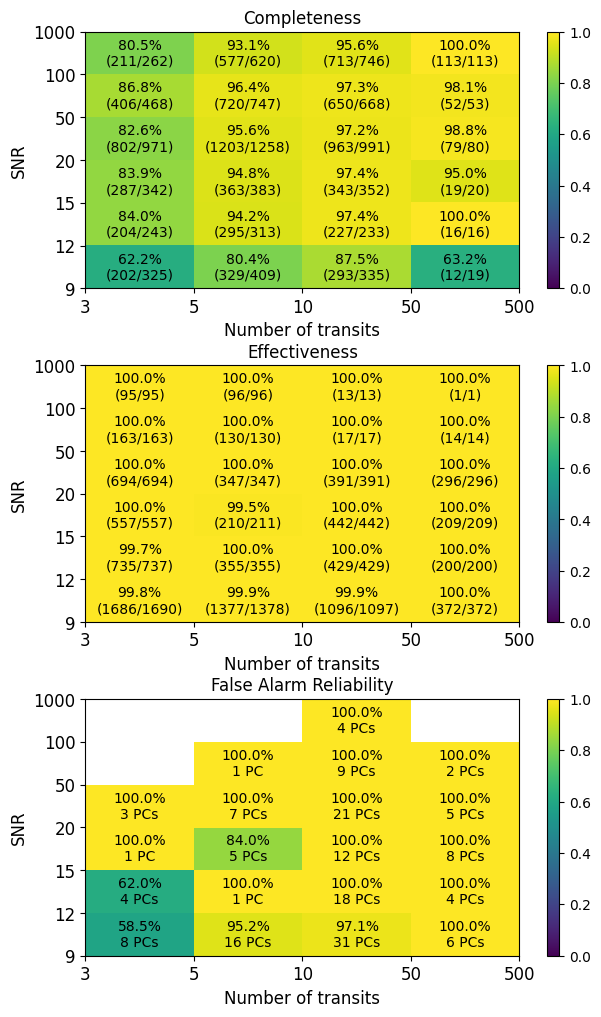

In [39]:
plot_results(diffEvoThresholds, scr, inj, obs, 
             "spn", np.array([9,12,15,20,50,100,1000]), "SNR", 
             "N_transit", np.array([3,5,10,50,500]), "Number of transits", fs=12)

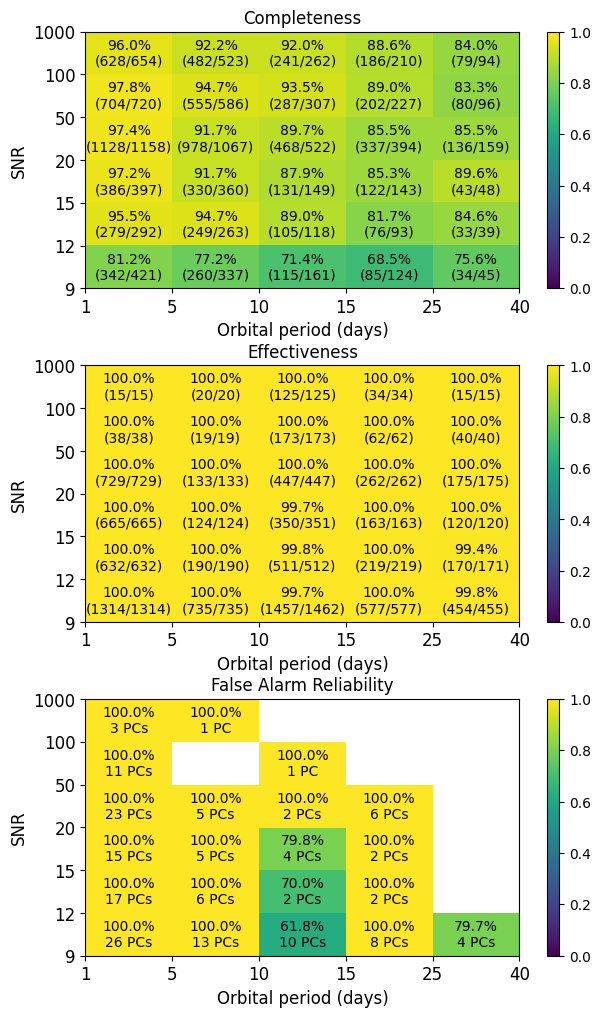

In [36]:
plot_results(diffEvoThresholds, scr, inj, obs, 
             "spn", np.array([9,12,15,20,50,100,1000]), "SNR", 
             "per", np.array([1,5,10,15,25,40]), "Orbital period (days)", fs=12)